# Exploratory Data Analysis — Dataset verification
This notebook validates and inspects the image dataset in `data/processed/`.

It will:
- Walk the directory recursively and infer labels from parent folder names
- Check for corrupted images
- Report counts per class, common image sizes/formats, aspect ratios
- Save a CSV summary to `reports/data_summary.csv`
- Plot class balance and some sample images


In [15]:
import os
from pathlib import Path
from PIL import Image, ImageFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Paths
DATA_DIR = Path("../data/processed")
REPORTS_DIR = Path("reports")
FIGURES_DIR = REPORTS_DIR / "figures"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [16]:
IMG_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}

def find_image_files(root: Path):
    """Recursively find image files under root, yield Path objects."""
    root = Path(root)
    files = []
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            files.append(p)
    return files

def infer_label_from_path(p: Path, root: Path):
    """
    Infer label by taking the folder name relative to root.
    Behavior:
     - If path is .../root/label/xxx.jpg -> returns 'label'
     - If path deeper (e.g. root/label/sub/xxx) -> returns first folder after root
     - If no parent (unlikely) -> returns '' (empty)
    """
    try:
        rel = p.relative_to(root)
        parts = rel.parts
        if len(parts) >= 2:
            return parts[0]
        elif len(parts) == 1:
            # file directly under root -> unknown label
            return ""
    except Exception:
        return ""
    return ""


In [17]:
image_paths = find_image_files(DATA_DIR)
len_image_paths = len(image_paths)
print(f"Found {len_image_paths} image files under {DATA_DIR}")

# Quick bail-out if no files found
if len_image_paths == 0:
    raise SystemExit(f"No images found under {DATA_DIR}. Please check the path.")

Found 8785 image files under ../data/processed


In [18]:
rows = []
corrupted = []
sizes = Counter()
formats = Counter()
aspect_ratios = []

for p in tqdm(image_paths, desc="Scanning images"):
    label = infer_label_from_path(p, DATA_DIR)
    try:
        with Image.open(p) as img:
            img.verify()  # verify checks for truncated or invalid files (moves file pointer)
        # reopen to read size/format because verify() may close file
        with Image.open(p) as img:
            width, height = img.size
            fmt = img.format or p.suffix.replace('.', '').upper()
    except Exception as e:
        corrupted.append((str(p), str(e)))
        rows.append({
            'path': str(p),
            'label': label,
            'width': None,
            'height': None,
            'format': None,
            'corrupted': True
        })
        continue

    aspect = round(width / height, 3) if height != 0 else None
    sizes[(width, height)] += 1
    formats[fmt] += 1
    if aspect is not None:
        aspect_ratios.append(aspect)

    rows.append({
        'path': str(p),
        'label': label,
        'width': width,
        'height': height,
        'format': fmt,
        'corrupted': False
    })

df = pd.DataFrame(rows)
df['area'] = df['width'] * df['height']
df.to_csv(REPORTS_DIR / "data_scan_raw.csv", index=False)
print(f"Saved raw scan CSV to {REPORTS_DIR/'data_scan_raw.csv'}")
print(f"Corrupted files found: {len(corrupted)}")

Scanning images: 100%|██████████| 8785/8785 [00:01<00:00, 5399.86it/s]

Saved raw scan CSV to reports/data_scan_raw.csv
Corrupted files found: 0


In [19]:
class_counts = df[df['corrupted'] == False]['label'].value_counts(dropna=False)
print("Class counts (non-corrupted files):")
print(class_counts)

# overall formats
print("\nImage formats (sample):")
print(formats.most_common(10))

# common sizes
print("\nTop 10 image sizes (w x h):")
for (w,h), c in sizes.most_common(10):
    print(f"{w}x{h}: {c}")

Class counts (non-corrupted files):
label
train    5939
test     1991
val       855
Name: count, dtype: int64

Image formats (sample):
[('PNG', 8361), ('JPEG', 424)]

Top 10 image sizes (w x h):
256x256: 8785


In [20]:
summary = {
    'total_images': len_image_paths,
    'corrupted_images': len(corrupted),
    'unique_labels': int(df['label'].nunique()),
    'labels': class_counts.to_dict(),
    'top_formats': formats.most_common(5),
    'top_sizes': [({'w':w,'h':h}, c) for (w,h), c in sizes.most_common(10)]
}
# Save summary CSV (simpler for humans); also save the full df
pd.DataFrame([summary]).to_json(REPORTS_DIR / "data_summary.json", orient='records', indent=2)
df.to_csv(REPORTS_DIR / "data_summary.csv", index=False)
print(f"Saved summary files to {REPORTS_DIR}")

Saved summary files to reports


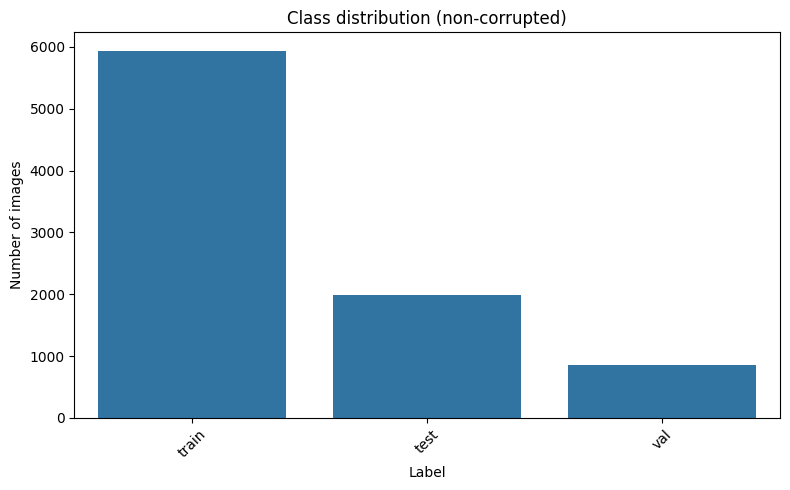

In [21]:
plt.figure(figsize=(8,5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class distribution (non-corrupted)")
plt.ylabel("Number of images")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "class_distribution.png", dpi=150)
plt.show()

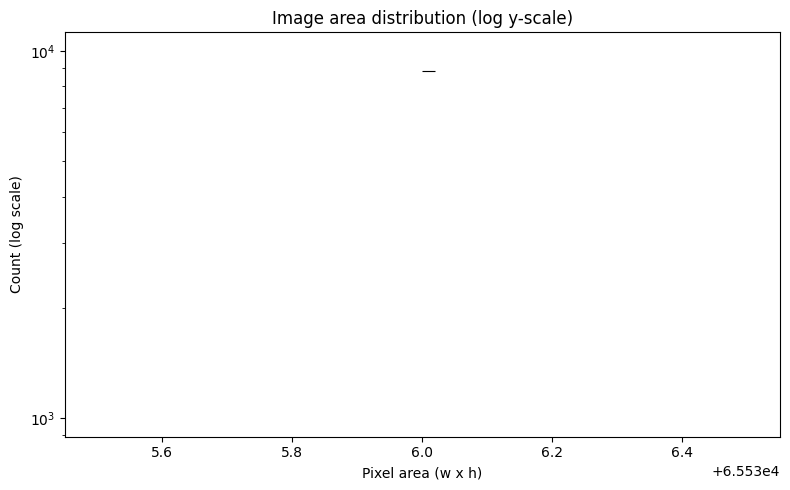

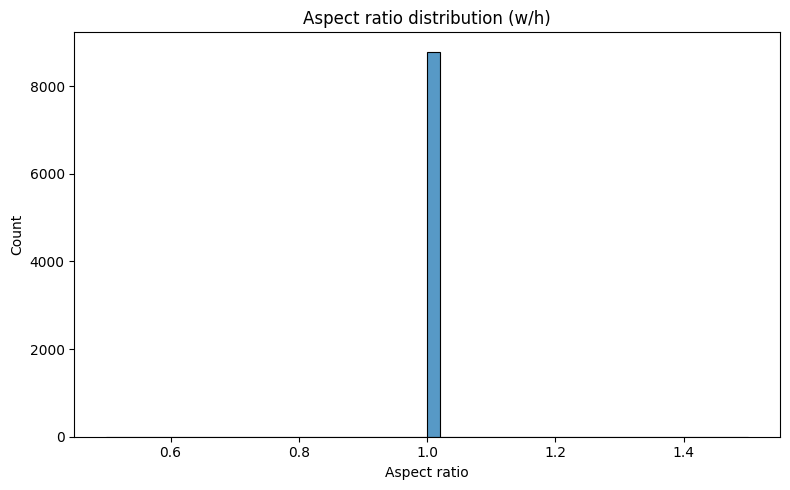

In [22]:
# Area distribution (only non-corrupted)
plt.figure(figsize=(8,5))
sns.histplot(df[df['corrupted'] == False]['area'].dropna(), bins=50, log_scale=(False, True))
plt.title("Image area distribution (log y-scale)")
plt.xlabel("Pixel area (w x h)")
plt.ylabel("Count (log scale)")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "area_distribution.png", dpi=150)
plt.show()

# Aspect ratio
plt.figure(figsize=(8,5))
sns.histplot([a for a in aspect_ratios if a is not None], bins=50)
plt.title("Aspect ratio distribution (w/h)")
plt.xlabel("Aspect ratio")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "aspect_ratio_distribution.png", dpi=150)
plt.show()

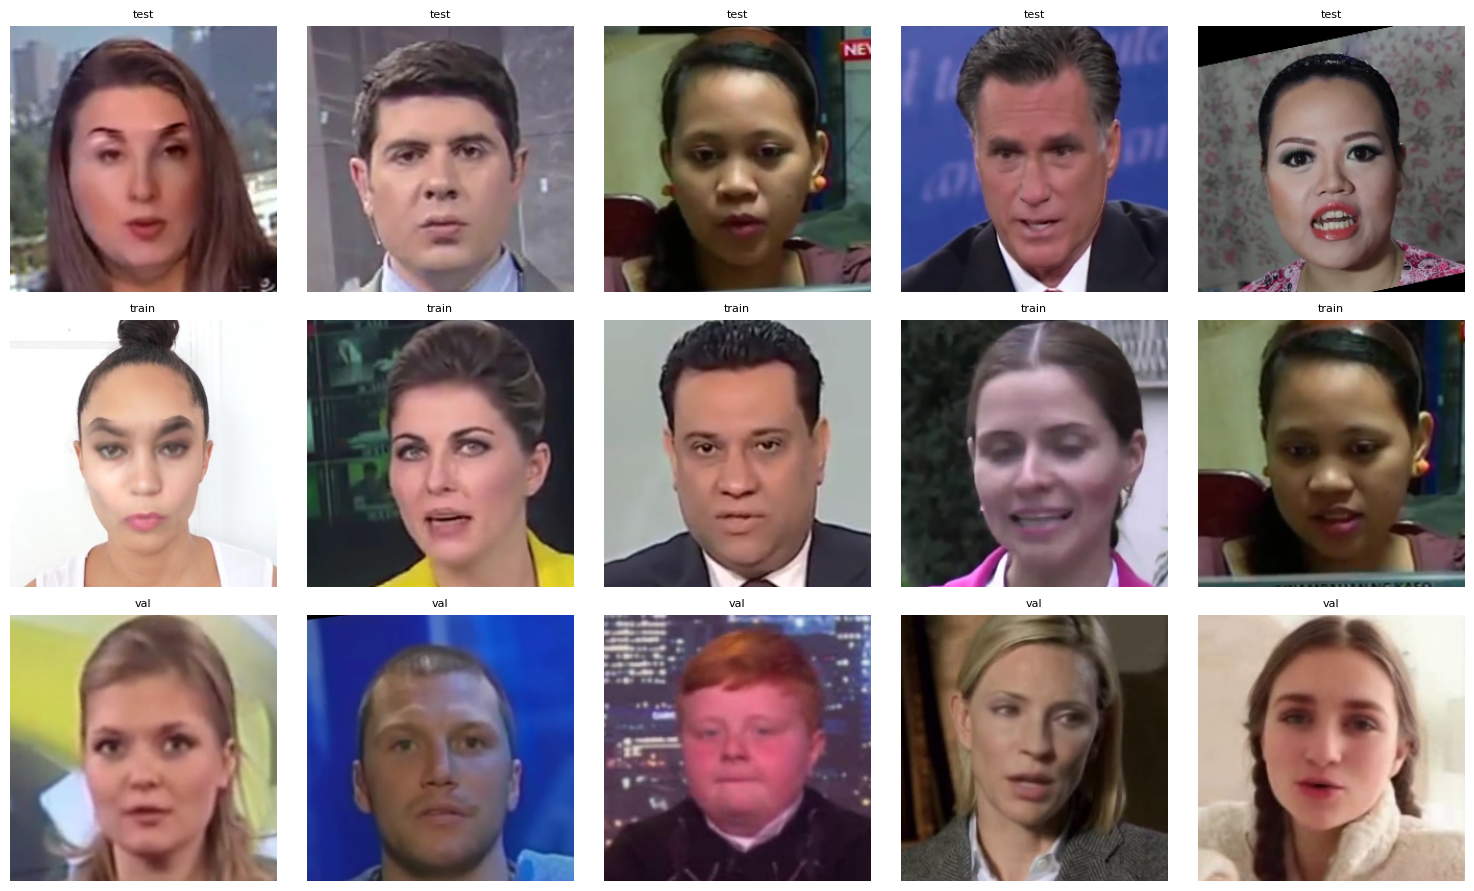

Saved sample grid to reports/figures/samples_per_class.png


In [23]:
from math import ceil
import random
def show_samples(df, n_per_class=5, random_seed=42):
    labels = sorted(df['label'].unique())
    samples = []
    for label in labels:
        sample_paths = df[(df['label'] == label) & (df['corrupted'] == False)]['path'].tolist()
        if len(sample_paths) == 0:
            continue
        random.seed(random_seed)
        chosen = random.sample(sample_paths, min(n_per_class, len(sample_paths)))
        samples.append((label, chosen))
    # plot
    max_cols = max(len(chosen) for _, chosen in samples) if samples else 0
    n_rows = len(samples)
    fig, axes = plt.subplots(n_rows, max_cols, figsize=(max_cols*3, n_rows*3))
    if n_rows == 0:
        print("No samples to show.")
        return
    if n_rows == 1:
        axes = np.expand_dims(axes, 0)
    for i, (label, chosen) in enumerate(samples):
        for j in range(max_cols):
            ax = axes[i][j] if max_cols>1 else axes[i]
            ax.axis('off')
            if j < len(chosen):
                p = chosen[j]
                try:
                    img = Image.open(p).convert("RGB")
                    ax.imshow(img)
                    ax.set_title(label, fontsize=8)
                except Exception as e:
                    ax.text(0.5, 0.5, "err", ha='center')
    plt.tight_layout()
    out_path = FIGURES_DIR / "samples_per_class.png"
    plt.savefig(out_path, dpi=150)
    plt.show()
    print(f"Saved sample grid to {out_path}")

show_samples(df, n_per_class=5)

In [24]:
if corrupted:
    print("Examples of corrupted files and errors:")
    for p, err in corrupted[:20]:
        print(f"{p} -> {err}")
else:
    print("No corrupted files found.")

No corrupted files found.


In [25]:
def quick_recommendations(df):
    recs = []
    # class imbalance
    counts = df[df['corrupted'] == False]['label'].value_counts()
    if not counts.empty:
        max_c = counts.max()
        min_c = counts.min()
        if max_c / (min_c + 1e-9) > 1.5:
            recs.append("Class imbalance detected. Consider data augmentation or resampling.")
    # image size diversity
    unique_sizes = df[df['corrupted'] == False][['width','height']].dropna().drop_duplicates()
    if len(unique_sizes) > 20:
        recs.append("Large diversity of image sizes; consider resizing to a common target (e.g., 224x224).")
    # corrupted files
    if df['corrupted'].sum() > 0:
        recs.append(f"{int(df['corrupted'].sum())} corrupted images found — remove or fix them before training.")
    if not recs:
        recs.append("No major issues detected. Proceed to build preprocessing and training pipeline.")
    return recs

for r in quick_recommendations(df):
    print("- " + r)

- Class imbalance detected. Consider data augmentation or resampling.


# Next steps
1. Fix or remove corrupted images (see `reports/data_scan_raw.csv` and corrupted file list printed above).  
2. Decide on a target input resolution (e.g., 224x224) and implement resizing/augmentation in `src/features/build_features.py`.  
3. If strong class imbalance exists, plan augmentation or sampling (weighted loss, oversampling, or class-balanced batches).  
4. Add unit tests that at least assert no corrupted images remain and expected labels are present for train/val/test splits.

## Class imbalance
Algorithms tend to focus on the majority class, leading to poor performance on the minority class
- Imbalanced data may result in overfitting to the majority class or underfitting the minority class
- Accuracy could report 99% in fraud detection problem by predicting all cases as 'Not Fraud' ignoring minority class performance

Goal is to create a balanced training dataset(ex: aiming for 50:50 ratio in binary problems) for better model performance.